# Table of Contents

* [Background](#Data-sources-background-information)
* [Data Import](#Data-import)
    * [Home Price](#Zillow-Home-price-data)
    * [Rent Price](#Zillow-Rent-Price-data)
    * [Construction](#Construction-data)
    * [Vacancy](#Rental-vacancy)
    * [Population](#Population)
* [Merging Dataframes](#Merging-final-DFs)
* [Plots](#Plotting)


## Data sources background information

| Data             | Source | Year or time period available | year or time period focus | rows  | link                                                                                                          | format | key                           | filename                                      |
|------------------|--------|-------------------------------|---------------------------|-------|---------------------------------------------------------------------------------------------------------------|--------|-------------------------------|-----------------------------------------------|
| rent prices      | Zillow | 2014-2020                     | 2019                      | 3234  | https://www.zillow.com/research/data/                                                                         | csv    | zip code                      | Zip_ZORI_AllHomesPlusMultifamily_Smoothed.csv |
| home prices      | Zillow | 1996-2020                     | 2019                      | 30442 | https://www.zillow.com/research/data/                                                                         | csv    | zip code                      | Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv  |
| new construction | Census | 2014-2019                     | 2019                      | 384   | https://www.census.gov/construction/bps/msaannual.html                                                        | xls    | CBSA                          | msaannual_201999.xls                          |
| rental vacancy   | Census | 2015-2020                     | 2019                      | 75    | https://www.census.gov/housing/hvs/data/rates.html                                                            | xlsx   | Metropolitan Statistical Area | tab4_msa_15_20_rvr.xlsx                       |
| population       | Census | 2010-2019                     | 2019                      | 81434 | https://www.census.gov/data/tables/time-series/demo/popest/2010s-total-metro-and-micro-statistical-areas.html | csv    | FIPS codes                    | cbsa-est2019-alldata.csv                      |


## Zillow rent prices

https://www.zillow.com/research/methodology-zori-repeat-rent-27092/

Zillow Observed Rent Index (ZORI): A smoothed measure of the typical observed market rate rent across a given region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by computing the mean of listed rents that fall into the 40th to 60th percentile range for all homes and apartments in a given region, which is once again weighted to reflect the rental housing stock. Details available in ZORI methodology.

What’s available to rent at any given time can change rapidly, and measures of median or average prices across time may not reflect actual market-based movements in rent prices, but instead simply reflect the fact that certain unit types are available at different times. ZORI solves this challenge by calculating price differences for the same rental unit over time, then aggregating those differences across all properties repeatedly listed for rent on Zillow.

Once the index is computed, it is smoothed using a three-month exponentially weighted moving average. Prior to publication, both the raw and smoothed indices are checked against a set of heuristics based on statistics of the time series to flag potential data quality issues so they can be investigated and fixed, or a determination can be made not to publish the series.

To make the index more interpretable, we attach a dollar value to the latest data point in the series and use the index’s month-to-month changes to chain the dollar value back in time. The dollar amount is calculated by taking the mean of the middle 20% (the 40-to-60 percentile) of the asking rent for observations from the most recent month. Using the mean of the middle quintile instead of a straight median better captures small changes in the market, while also reducing noise. To correct for bias in list rents, we use the same weights described above to make the dollar-denominated amount representative of the market of available homes. 

Zillow neigborhoods: https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods@public/information/

## Zillow home prices

Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. Zillow publishes top-tier ZHVI (typical value for homes within the 65th to 95th percentile range for a given region) and bottom-tier ZHVI (typical value for homes that fall within the 5th to 35th percentile range for a given region). Zillow also publishes ZHVI for all single-family residences (typical value for all single-family homes in a given region), for condo/coops, for all homes with 1, 2, 3, 4 and 5+ bedrooms ($), and the ZHVI per square foot (typical value of all homes per square foot calculated by taking the estimated home value for each home in a given region and dividing it by the home’s square footage). Check out this overview of ZHVI and a deep-dive into its methodology. The Zillow Home Value Forecast (ZHVF) is the one-year forecast of the ZHVI.

## New construction

New privately-owned residential construction - A monthly survey of 9,000 selected permit-issuing places; and an annual census of an additional 11,000 permit places that are not in the monthly sample. The monthly sample of permit-issuing places was selected using a stratified systematic sample procedure. All permit places located in selected large metropolitan areas were selected with certainty. The remaining places were stratified by state.

## Rental vacancy data

from here https://www.census.gov/housing/hvs/methodology/index.html

The CPS/HVS is administered by the Census Bureau using a probability selected sample of about 72,000 housing units, both occupied and vacant. The fieldwork is conducted during the calendar week that includes the 19th of the month. The questions refer to activities during the prior week; that is, the week that includes the 12th of the month. Households from all 50 states and the District of Columbia are in the survey for 4 consecutive months, out for 8, and then return for another 4 months before leaving the sample permanently. This design ensures a high degree of continuity from one month to the next (as well as over the year). The 4-8-4 sampling scheme has the added benefit of allowing the constant replenishment of the sample without excessive burden to respondents.

## Population data

Each year, the United States Census Bureau produces and publishes estimates of the population for the
nation, states, counties, state/county equivalents, and Puerto Rico.1 We estimate the resident population for
each year since the most recent decennial census by using measures of population change. The resident
population includes all people currently residing in the United States.

## FIPS, CBSA, Zip Codes, geocodes etc

CBSA = core based statistical areas

New metropolitan and micropolitan statistical area definitions were announced by OMB on June 6, 2003, based on application of the 2000 standards with Census 2000 data. Metropolitan and Micropolitan Statistical Areas are collectively referred to as Core-Based Statistical Areas.

Metropolitan statistical areas have at least one urbanized area of 50,000 or more population, plus adjacent territory that has a high degree of social and economic integration with the core as measured by commuting ties.
Micropolitan statistical areas are a new set of statistical areas that have at least one urban cluster of at least 10,000 but less than 50,000 population, plus adjacent territory that has a high degree of social and economic integration with the core as measured by commuting ties.
Metropolitan and micropolitan statistical areas are defined in terms of whole counties or county equivalents, including the six New England states. As of June 6, 2003, there are 362 metropolitan statistical areas and 560 micropolitan statistical areas in the United States.

https://www.huduser.gov/portal/datasets/usps_crosswalk.html

zip code tabulation areas? https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html

## Data import

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sweetviz as sv
from datetime import datetime as dt
from matplotlib.ticker import FuncFormatter

#%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format
plt.style.use('seaborn-white')

### Zillow Home price data

In [181]:
home_prices = pd.read_csv('../data/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv')

In [182]:
home_prices.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,nan,...,"1,397,980.0000","1,389,522.0000","1,383,244.0000","1,380,903.0000","1,385,338.0000","1,386,299.0000","1,385,537.0000","1,377,219.0000","1,366,529.0000","1,351,955.0000"
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,"362,440.0000",...,"969,701.0000","968,746.0000","967,546.0000","966,119.0000","965,833.0000","966,867.0000","968,066.0000","967,947.0000","966,726.0000","964,844.0000"
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,nan,...,"1,597,185.0000","1,590,668.0000","1,584,963.0000","1,581,334.0000","1,584,746.0000","1,586,066.0000","1,582,635.0000","1,575,709.0000","1,569,296.0000","1,569,607.0000"
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,"200,594.0000",...,"336,361.0000","336,399.0000","336,382.0000","336,475.0000","336,202.0000","336,398.0000","336,859.0000","337,928.0000","338,853.0000","339,429.0000"
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,"544,060.0000",...,"1,200,264.0000","1,198,154.0000","1,195,523.0000","1,193,421.0000","1,193,009.0000","1,194,815.0000","1,196,093.0000","1,196,435.0000","1,195,008.0000","1,194,721.0000"


In [183]:
home_prices.shape

(30421, 303)

In [184]:
# melt it
home_prices_l = pd.melt(home_prices, id_vars=home_prices.columns[range(9)], var_name='month_date', value_name='house_price')

In [185]:
home_prices_l.head()
home_prices_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8943774 entries, 0 to 8943773
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   RegionID     int64  
 1   SizeRank     int64  
 2   RegionName   int64  
 3   RegionType   object 
 4   StateName    object 
 5   State        object 
 6   City         object 
 7   Metro        object 
 8   CountyName   object 
 9   month_date   object 
 10  house_price  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 750.6+ MB


In [186]:
# convert to date
home_prices_l['month_date'] = pd.to_datetime(home_prices_l['month_date'])

In [187]:
home_prices_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8943774 entries, 0 to 8943773
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   RegionID     int64         
 1   SizeRank     int64         
 2   RegionName   int64         
 3   RegionType   object        
 4   StateName    object        
 5   State        object        
 6   City         object        
 7   Metro        object        
 8   CountyName   object        
 9   month_date   datetime64[ns]
 10  house_price  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 750.6+ MB


In [188]:
# just keep 2019 for now
home_prices_l_2019 = home_prices_l[(home_prices_l['month_date'] > '2018-12-31') & (home_prices_l['month_date'] < '2020-01-01')].copy()
home_prices_l_2019['month_date'].unique()

array(['2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [189]:
home_prices_l_2019 = home_prices_l_2019.drop(['SizeRank', 'RegionType', 'StateName', 'RegionID'], axis=1)
home_prices_l_2019.head()

,RegionName,State,City,Metro,CountyName,month_date,house_price
8396196,10025,NY,New York,New York-Newark-Jersey City,New York County,2019-01-31,"1,442,745.0000"
8396197,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,"973,282.0000"
8396198,10023,NY,New York,New York-Newark-Jersey City,New York County,2019-01-31,"1,689,338.0000"
8396199,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,2019-01-31,"337,064.0000"
8396200,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01-31,"1,207,290.0000"


### Zillow Rent Price data

In [190]:
rent_prices = pd.read_csv('../data/Zip_ZORI_AllHomesPlusMultifamily_Smoothed.csv')

In [191]:
rent_prices.head()

,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06
0,61639,10025,1,"3,134.0000","3,065.0000","3,082.0000","3,159.0000","3,119.0000","3,099.0000","3,134.0000",...,"3,371.0000","3,348.0000","3,331.0000","3,327.0000","3,332.0000","3,395.0000","3,370.0000","3,306.0000","3,275.0000","3,213.0000"
1,84654,60657,2,"1,673.0000","1,663.0000","1,674.0000","1,711.0000","1,725.0000","1,770.0000","1,768.0000",...,"1,947.0000","1,924.0000","1,912.0000","1,904.0000","1,936.0000","1,974.0000","1,974.0000","1,974.0000","1,970.0000","1,953.0000"
2,61637,10023,3,"3,087.0000","3,025.0000","3,085.0000","3,138.0000","3,157.0000","3,225.0000","3,202.0000",...,"3,312.0000","3,314.0000","3,328.0000","3,263.0000","3,322.0000","3,315.0000","3,333.0000","3,305.0000","3,269.0000","3,246.0000"
3,91982,77494,4,"1,813.0000","1,877.0000","1,854.0000","1,885.0000","1,898.0000","1,925.0000","1,923.0000",...,"1,864.0000","1,862.0000","1,855.0000","1,862.0000","1,865.0000","1,866.0000","1,869.0000","1,861.0000","1,855.0000","1,873.0000"
4,84616,60614,5,"1,870.0000","1,782.0000","1,840.0000","1,869.0000","1,901.0000","1,915.0000","1,938.0000",...,"2,166.0000","2,147.0000","2,137.0000","2,129.0000","2,128.0000","2,146.0000","2,160.0000","2,182.0000","2,185.0000","2,174.0000"


In [192]:
rent_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 81 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    3234 non-null   int64  
 1   RegionName  3234 non-null   int64  
 2   SizeRank    3234 non-null   int64  
 3   2014-01     2119 non-null   float64
 4   2014-02     2223 non-null   float64
 5   2014-03     2256 non-null   float64
 6   2014-04     2439 non-null   float64
 7   2014-05     2592 non-null   float64
 8   2014-06     2694 non-null   float64
 9   2014-07     2719 non-null   float64
 10  2014-08     2733 non-null   float64
 11  2014-09     2663 non-null   float64
 12  2014-10     2613 non-null   float64
 13  2014-11     2510 non-null   float64
 14  2014-12     2490 non-null   float64
 15  2015-01     2609 non-null   float64
 16  2015-02     2612 non-null   float64
 17  2015-03     2854 non-null   float64
 18  2015-04     2857 non-null   float64
 19  2015-05     2908 non-null  

In [193]:
rent_prices.shape

(3234, 81)

In [194]:
# don't need these 
rent_prices = rent_prices.drop(['SizeRank', 'RegionID'], axis=1)

In [195]:
rent_prices.shape

(3234, 79)

In [196]:
rent_prices_l = pd.melt(rent_prices, id_vars='RegionName', var_name='month_date', value_name='rent_price')
rent_prices_l.head()

,RegionName,month_date,rent_price
0,10025,2014-01,"3,134.0000"
1,60657,2014-01,"1,673.0000"
2,10023,2014-01,"3,087.0000"
3,77494,2014-01,"1,813.0000"
4,60614,2014-01,"1,870.0000"


In [197]:
rent_prices_l.shape

(252252, 3)

In [198]:
rent_prices_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252252 entries, 0 to 252251
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionName  252252 non-null  int64  
 1   month_date  252252 non-null  object 
 2   rent_price  232560 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ MB


In [199]:
# convert to date
rent_prices_l['month_date'] = pd.to_datetime(rent_prices_l['month_date'])

In [200]:
# just keep 2019
rent_prices_l_2019 = rent_prices_l[(rent_prices_l['month_date'] > '2018-12-31') & (rent_prices_l['month_date'] < '2020-01-01')].copy()
rent_prices_l_2019['month_date'].unique()

array(['2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [201]:
rent_prices_l_2019.shape

(38808, 3)

In [202]:
rent_prices_l_2019['month_date'] = rent_prices_l_2019['month_date'].dt.strftime('%Y-%m')

In [203]:
rent_prices_l_2019['month_date'].unique()

array(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
      dtype=object)

In [204]:
# change back to str to join with rent
home_prices_l_2019['month_date'] = home_prices_l_2019['month_date'].dt.strftime('%Y-%m')

In [205]:
home_prices_l_2019['month_date'].unique()

array(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
      dtype=object)

In [206]:
prices = pd.merge(home_prices_l_2019, rent_prices_l_2019, on=['RegionName', 'month_date'])
prices.head(100)

,RegionName,State,City,Metro,CountyName,month_date,house_price,rent_price
0,10025,NY,New York,New York-Newark-Jersey City,New York County,2019-01,"1,442,745.0000","3,213.0000"
1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01,"973,282.0000","1,860.0000"
2,10023,NY,New York,New York-Newark-Jersey City,New York County,2019-01,"1,689,338.0000","3,212.0000"
3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,2019-01,"337,064.0000","1,834.0000"
4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01,"1,207,290.0000","2,090.0000"
...,...,...,...,...,...,...,...,...
95,90044,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,2019-01,"453,879.0000","1,795.0000"
96,85710,AZ,Tucson,Tucson,Pima County,2019-01,"188,283.0000","1,101.0000"
97,92683,CA,Westminster,Los Angeles-Long Beach-Anaheim,Orange County,2019-01,"692,358.0000","2,414.0000"
98,85225,AZ,Chandler,Phoenix-Mesa-Scottsdale,Maricopa County,2019-01,"269,817.0000","1,348.0000"


In [207]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38808 entries, 0 to 38807
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RegionName   38808 non-null  int64  
 1   State        38808 non-null  object 
 2   City         38808 non-null  object 
 3   Metro        38808 non-null  object 
 4   CountyName   38808 non-null  object 
 5   month_date   38808 non-null  object 
 6   house_price  38808 non-null  float64
 7   rent_price   37981 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 2.7+ MB


In [208]:
# we are missing some states with rent data
rent_states = set(prices['State'].sort_values().unique())

In [209]:
# make states set
states = set(["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"])

In [210]:
states.difference(rent_states)

{'AK', 'ME', 'MT', 'ND', 'SD', 'VT', 'WV', 'WY'}

In [211]:
# also, some zip codes don't have rent for each month
rent_prices_l_2019[rent_prices_l_2019['RegionName'] == 95823]

,RegionName,month_date,rent_price
194182,95823,2019-01,nan
197416,95823,2019-02,"1,620.0000"
200650,95823,2019-03,"1,633.0000"
203884,95823,2019-04,"1,689.0000"
207118,95823,2019-05,"1,680.0000"
210352,95823,2019-06,"1,654.0000"
213586,95823,2019-07,"1,642.0000"
216820,95823,2019-08,"1,637.0000"
220054,95823,2019-09,"1,659.0000"
223288,95823,2019-10,"1,608.0000"


### Construction data

In [212]:
# skip 1-5 and 7 row ids
construction = pd.read_excel('../data/msaannual_201999_building_construction.xls', header=5, skiprows=[range(5), 6])
construction.head()
#construction.shape

,CSA,CBSA,Name,Total,1 Unit,2 Units,3 and 4 Units,5 Units or More,Num of Structures With 5 Units or More
0,999,10180,"Abilene, TX ...",370,354,16,0,0,0
1,184,10420,"Akron, OH ...",945,856,2,32,55,1
2,999,10500,"Albany, GA ...",402,182,0,0,220,10
3,440,10540,"Albany-Lebanon, OR ...",716,466,0,0,250,26
4,104,10580,"Albany-Schenectady-Troy, NY ...",1870,1120,40,45,665,48


In [213]:
# rename cols
construction = construction.rename(columns={'1 Unit' : 'unit_1',
                  '2 Unit' : 'unit_2',
                  '3 and 4 Units': 'unit_34',
                  '5 Units or More': 'unit_5',
                  'Num of Structures With 5 Units or More': 'unit_for_5orMore'})
construction.head()

,CSA,CBSA,Name,Total,unit_1,2 Units,unit_34,unit_5,unit_for_5orMore
0,999,10180,"Abilene, TX ...",370,354,16,0,0,0
1,184,10420,"Akron, OH ...",945,856,2,32,55,1
2,999,10500,"Albany, GA ...",402,182,0,0,220,10
3,440,10540,"Albany-Lebanon, OR ...",716,466,0,0,250,26
4,104,10580,"Albany-Schenectady-Troy, NY ...",1870,1120,40,45,665,48


### Rental vacancy

In [214]:
# this file has merged cells and other stuff
vacancy = pd.read_excel('../data/tab4_msa_15_20_rvr.xlsx', 
                        header=3, 
                        usecols='B:J') 
                        #skiprows=2, 
                        #skipfooter=509)

vacancy = vacancy.iloc[4:,:]
vacancy.shape

(549, 9)

In [215]:
# drop rows without MSA name
vacancy = vacancy.dropna(subset=['Metropolitan Statistical Area'], axis=0).reset_index()
vacancy.shape

(455, 10)

In [216]:
# rename cols
# there is an issue getting years for these quarters.. maybe just use 2019 for now?
vacancy = vacancy.rename(columns={'Metropolitan Statistical Area' : 'cbsa_title',
                  'First Quarter 2020'  : 'Q1',
                  'Margin of Error1'    : 'ErrorMargin1',
                  'Second Quarter 2020' : 'Q2',
                  'Margin of Error1.1'  : 'ErrorMargin2',
                  'Third Quarter 2020'  : 'Q3',
                  'Margin of Error1.2'  : 'ErrorMargin3',
                  'Fourth Quarter 2020' : 'Q4',
                  'Margin of Error1.3'  : 'ErrorMargin4'})
vacancy.head()

,index,cbsa_title,First Quarter 2020,ErrorMargin1,Second Quarter 2020,ErrorMargin2,Third Quarter 2020,ErrorMargin3,Fourth Quarter 2020,ErrorMargin4
0,4,"Akron, OH .......................................",10.2000,9.2000,NaN,NaN,NaN,NaN,NaN,NaN
1,5,"Albany-Schenectady-Troy, NY .....................",7.9000,6.7000,NaN,NaN,NaN,NaN,NaN,NaN
2,6,"Albuquerque, NM..................................",4.3000,2.8000,NaN,NaN,NaN,NaN,NaN,NaN
3,7,"Allentown-Bethlehem-Easton, PA-NJ................",4.5000,5.9000,NaN,NaN,NaN,NaN,NaN,NaN
4,8,"Atlanta-Sandy Springs-Roswell, GA1...............",6.9000,2.5000,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
# keep 2019 data
vacancy = vacancy.iloc[76:151, :]
vacancy.tail()

,index,cbsa_title,First Quarter 2020,ErrorMargin1,Second Quarter 2020,ErrorMargin2,Third Quarter 2020,ErrorMargin3,Fourth Quarter 2020,ErrorMargin4
146,159,"Tulsa, OK........................................",7,5.3000,8.6000,5.4000,10.3000,5.9000,7.9000,5.2000
147,160,"Urban Honolulu, HI29.............................",5.9000,2.7000,6,2.7000,6,2.7000,4.6000,2.4000
148,161,"Virginia Beach-Norfolk-Newport News, VA-NC30.....",8.5000,5.5000,6.2000,4.1000,6.5000,4.5000,7.3000,5
149,162,"Washington-Arlington-Alexandria, DC-VA-MD-WV.....",5.9000,2.4000,6.1000,2.4000,5.1000,2.2000,5.2000,2.3000
150,163,"Worcester, MA....................................",4.5000,4.4000,4.7000,4.6000,1.1000,2.2000,0.4000,1.2000


In [218]:
vacancy.shape

(75, 10)

In [219]:
# vacancy.columns.values
# annoying can't figure out how to get col names

vacancy = vacancy.rename(columns= {vacancy.columns[3]: "Q1" })
vacancy = vacancy.rename(columns= {vacancy.columns[5]: "Q2" })
vacancy = vacancy.rename(columns= {vacancy.columns[7]: "Q3" })
vacancy = vacancy.rename(columns= {vacancy.columns[9]: "Q4" })
vacancy.head()

,index,cbsa_title,First Quarter 2020,Q1,Second Quarter 2020,Q2,Third Quarter 2020,Q3,Fourth Quarter 2020,Q4
76,89,"Akron, OH .......................................",2,4.1000,3.6000,6.1000,4,5.7000,14.2000,10.1000
77,90,"Albany-Schenectady-Troy, NY .....................",7.9000,6.6000,10.8000,7,15.5000,9.2000,15.6000,8.8000
78,91,"Albuquerque, NM..................................",7.1000,3.7000,6.8000,3.6000,7.8000,3.7000,4.4000,2.7000
79,92,"Allentown-Bethlehem-Easton, PA-NJ................",7.7000,7.7000,3.2000,5,0,(z),6.1000,7.2000
80,93,"Atlanta-Sandy Springs-Roswell, GA1...............",7.8000,2.7000,7.6000,2.7000,6.4000,2.5000,5.9000,2.3000


In [220]:
vacancy.tail()

,index,cbsa_title,First Quarter 2020,Q1,Second Quarter 2020,Q2,Third Quarter 2020,Q3,Fourth Quarter 2020,Q4
146,159,"Tulsa, OK........................................",7,5.3000,8.6000,5.4000,10.3000,5.9000,7.9000,5.2000
147,160,"Urban Honolulu, HI29.............................",5.9000,2.7000,6,2.7000,6,2.7000,4.6000,2.4000
148,161,"Virginia Beach-Norfolk-Newport News, VA-NC30.....",8.5000,5.5000,6.2000,4.1000,6.5000,4.5000,7.3000,5
149,162,"Washington-Arlington-Alexandria, DC-VA-MD-WV.....",5.9000,2.4000,6.1000,2.4000,5.1000,2.2000,5.2000,2.3000
150,163,"Worcester, MA....................................",4.5000,4.4000,4.7000,4.6000,1.1000,2.2000,0.4000,1.2000


In [221]:
# this doesn't have the actual CBSA codes, so get two files and merge them and join with this
# the two files are here from OMB:
# https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html

CBSAs2 = pd.read_excel('../data/list2_2020.xls', header=2)
# drop footer
CBSAs2 = CBSAs2.iloc[:1269, :]
CBSAs2.tail()

,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Principal City Name,FIPS State Code,FIPS Place Code
1264,49660,"Youngstown-Warren-Boardman, OH-PA",Metropolitan Statistical Area,Youngstown,39.0000,"88,000.0000"
1265,49700,"Yuba City, CA",Metropolitan Statistical Area,Yuba City,6.0000,"86,972.0000"
1266,49740,"Yuma, AZ",Metropolitan Statistical Area,Yuma,4.0000,"85,540.0000"
1267,49780,"Zanesville, OH",Micropolitan Statistical Area,Zanesville,39.0000,"88,084.0000"
1268,49820,"Zapata, TX",Micropolitan Statistical Area,Zapata,48.0000,"80,716.0000"


In [222]:
# clean up column names
CBSAs2.columns = CBSAs2.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [223]:
CBSAs2.head(1)

,cbsa_code,cbsa_title,metropolitan/micropolitan_statistical_area,principal_city_name,fips_state_code,fips_place_code
0,10100,"Aberdeen, SD",Micropolitan Statistical Area,Aberdeen,46.0000,100.0000


In [224]:
# get rid of newline in col
CBSAs2 = CBSAs2.drop(['principal_city_name','fips_place_code'], axis=1)

In [225]:
CBSAs2.head(1)

,cbsa_code,cbsa_title,metropolitan/micropolitan_statistical_area,fips_state_code
0,10100,"Aberdeen, SD",Micropolitan Statistical Area,46.0000


In [226]:
# this is what we will merge
CBSAs = CBSAs2.iloc[:, [0,1]].copy()

In [227]:
CBSAs.head(100)

,cbsa_code,cbsa_title
0,10100,"Aberdeen, SD"
1,10140,"Aberdeen, WA"
2,10180,"Abilene, TX"
3,10220,"Ada, OK"
4,10300,"Adrian, MI"
...,...,...
95,13300,"Beeville, TX"
96,13340,"Bellefontaine, OH"
97,13380,"Bellingham, WA"
98,13420,"Bemidji, MN"


In [228]:
# clean up col for merge
vacancy['cbsa_title'] = vacancy['cbsa_title'].str.strip().str.replace('.', '')
vacancy.head()

,index,cbsa_title,First Quarter 2020,Q1,Second Quarter 2020,Q2,Third Quarter 2020,Q3,Fourth Quarter 2020,Q4
76,89,"Akron, OH",2,4.1000,3.6000,6.1000,4,5.7000,14.2000,10.1000
77,90,"Albany-Schenectady-Troy, NY",7.9000,6.6000,10.8000,7,15.5000,9.2000,15.6000,8.8000
78,91,"Albuquerque, NM",7.1000,3.7000,6.8000,3.6000,7.8000,3.7000,4.4000,2.7000
79,92,"Allentown-Bethlehem-Easton, PA-NJ",7.7000,7.7000,3.2000,5,0,(z),6.1000,7.2000
80,93,"Atlanta-Sandy Springs-Roswell, GA1",7.8000,2.7000,7.6000,2.7000,6.4000,2.5000,5.9000,2.3000


In [229]:
vacancy['cbsa_title'] = vacancy['cbsa_title'].str.replace('\d*$', '').str.replace('…', '')
vacancy['cbsa_title'] = vacancy['cbsa_title'].str.replace('Philadelphia-Camden-Wilmington, PA-NJ-DE-MD21', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD')
vacancy.head(50)
vacancy.tail(50)

,index,cbsa_title,First Quarter 2020,Q1,Second Quarter 2020,Q2,Third Quarter 2020,Q3,Fourth Quarter 2020,Q4
101,114,"Grand Rapids-Wyoming, MI",4.9000,6.2000,4.9000,5.6000,2.8000,4.7000,5.5000,7.2000
102,115,"Greensboro-High Point, NC",9.8000,7.5000,7.1000,5.8000,5.1000,4.7000,10.9000,6.7000
103,116,"Hartford-West Hartford-East Hartford, CT",3.1000,3.2000,4.5000,3.7000,5.9000,4.2000,3.6000,3.6000
104,117,"Houston-The Woodlands-Sugar Land, TX",10.6000,2.8000,11.8000,2.9000,12.4000,3.1000,10.8000,2.9000
105,118,"Indianapolis-Carmel-Anderson, IN",5.7000,3.6000,9.1000,4.8000,7.2000,4.2000,6.3000,3.6000
106,119,"Jacksonville, FL",4.7000,3.9000,6.9000,5,4.7000,4.1000,4.5000,3.9000
107,120,"Kansas City, MO-KS",13.1000,4.1000,5.8000,2.7000,9.5000,3.3000,11.9000,3.7000
108,121,"Knoxville, TN",3.6000,4.3000,9.7000,7.2000,10.1000,6.7000,5.2000,5
109,122,"Las Vegas-Henderson-Paradise, NV",6.4000,2.6000,4.8000,2.2000,5.2000,2.2000,5.6000,2.5000
110,123,"Little Rock-North Little Rock-Conway, AR",13.2000,9,9.8000,7.5000,10.8000,8.2000,12.1000,8.4000


In [230]:
vacancy = vacancy.drop(['index'], axis=1)

In [231]:
#CBSAs.to_csv('CBSAs.csv', index=False)

In [232]:
vacancy_merge = pd.merge(vacancy, CBSAs, how= 'left', on = 'cbsa_title')
# why duplicates?
# there is lots of issues - the names are outdated and the merge is not going to work
# since only 20 or so, just export and fix manually
#vacancy_merge.to_csv('vacancy_merge2.csv', index=False)

In [233]:
# just fix it manually
vacancy_merge2 = pd.read_csv('../data/vacancy_merge_fixed.csv')
vacancy_merge2.head()

,cbsa_title,Q1,ErrorMargin1,Q2,ErrorMargin2,Q3,ErrorMargin3,Q4,ErrorMargin4,cbsa_code
0,"Akron, OH",2.0000,4.1000,3.6000,6.1000,4.0000,5.7,14.2000,10.1000,10420
1,"Albany-Schenectady-Troy, NY",7.9000,6.6000,10.8000,7.0000,15.5000,9.2,15.6000,8.8000,10580
2,"Albuquerque, NM",7.1000,3.7000,6.8000,3.6000,7.8000,3.7,4.4000,2.7000,10740
3,"Allentown-Bethlehem-Easton, PA-NJ",7.7000,7.7000,3.2000,5.0000,0.0000,(z),6.1000,7.2000,10900
4,"Atlanta-Sandy Springs-Roswell, GA",7.8000,2.7000,7.6000,2.7000,6.4000,2.5,5.9000,2.3000,12060


In [234]:
construction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CSA               384 non-null    int64 
 1   CBSA              384 non-null    int64 
 2   Name              384 non-null    object
 3   Total             384 non-null    int64 
 4   unit_1            384 non-null    int64 
 5   2 Units           384 non-null    int64 
 6   unit_34           384 non-null    int64 
 7   unit_5            384 non-null    int64 
 8   unit_for_5orMore  384 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 27.1+ KB


In [235]:
# now merge with construction
vaca_constr = pd.merge(vacancy_merge2, construction, how= 'left', left_on = 'cbsa_code', right_on = 'CBSA')

In [236]:
vaca_constr.head()
vaca_constr.shape
vaca_constr[vaca_constr.isna().any(axis=1)]

,cbsa_title,Q1,ErrorMargin1,Q2,ErrorMargin2,Q3,ErrorMargin3,Q4,ErrorMargin4,cbsa_code,CSA,CBSA,Name,Total,unit_1,2 Units,unit_34,unit_5,unit_for_5orMore
25,"Grand Rapids-Wyoming, MI",4.9000,6.2000,4.9000,5.6000,2.8000,4.7,5.5000,7.2000,24330,nan,nan,NaN,nan,nan,nan,nan,nan,nan


### Population

In [237]:
# actually let's just use CBSA population data.. we don't need sub county..
population = pd.read_csv('../data/cbsa-est2019-alldata.csv', encoding = "ISO-8859-1")

In [238]:
population.head()

,CBSA,MDIV,STCOU,NAME,LSAD,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019
0,10180,nan,nan,"Abilene, TX",Metropolitan Statistical Area,165252,165252,165585,166634,167442,...,-5,-3,-9,23,-22,-17,-4,-5,-4,-9
1,10180,nan,"48,059.0000","Callahan County, TX",County or equivalent,13544,13545,13512,13511,13488,...,-1,-1,-1,-2,-2,-1,0,0,0,-1
2,10180,nan,"48,253.0000","Jones County, TX",County or equivalent,20202,20192,20238,20270,19870,...,1,3,14,5,1,1,-1,0,-1,-2
3,10180,nan,"48,441.0000","Taylor County, TX",County or equivalent,131506,131515,131835,132853,134084,...,-5,-5,-22,20,-21,-17,-3,-5,-3,-6
4,10420,nan,nan,"Akron, OH",Metropolitan Statistical Area,703200,703196,703031,703200,702109,...,-33,-12,-48,-87,-115,-48,-17,-27,-18,-22


In [239]:
population['LSAD'].unique()

array(['Metropolitan Statistical Area', 'County or equivalent',
       'Metropolitan Division', 'Micropolitan Statistical Area'],
      dtype=object)

In [240]:
#population.info()
# just keep what we need
population = population.loc[:, ['CBSA', 'NAME', 'LSAD', 'POPESTIMATE2019']]
population = population[population['LSAD'].isin(['Metropolitan Statistical Area', 'Micropolitan Statistical Area'])]

In [241]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 0 to 2795
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CBSA             926 non-null    int64 
 1   NAME             926 non-null    object
 2   LSAD             926 non-null    object
 3   POPESTIMATE2019  926 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 36.2+ KB


### ZIP and CBSA crosswalk files

In [242]:
# 4th quarter ZIP and CBSA crosswalk files:
# some ZIPs are in multiple CBSAs?
# how many unique do we have?
# from wikipedia, says there is around 900:
# https://en.wikipedia.org/wiki/List_of_core-based_statistical_areas

# load the CBSA to ZIP, since we have more zip data.. we could plot or get means of zips within multiple CBSAs
CBSA_to_ZIP = pd.read_excel('../data/CBSA_ZIP_122019.xlsx')

In [243]:
CBSA_to_ZIP.head()

,CBSA,ZIP,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,10100,57426,0.0011,0.0000,0.0006,0.0010
1,10100,57475,0.0017,0.0000,0.0006,0.0015
2,10100,57435,0.0007,0.0000,0.0000,0.0006
3,10100,57466,0.0010,0.0000,0.0000,0.0008
4,10100,57422,0.0003,0.0000,0.0000,0.0002


In [244]:
CBSA_to_ZIP.shape

(50754, 6)

In [245]:
prices.head()

,RegionName,State,City,Metro,CountyName,month_date,house_price,rent_price
0,10025,NY,New York,New York-Newark-Jersey City,New York County,2019-01,"1,442,745.0000","3,213.0000"
1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01,"973,282.0000","1,860.0000"
2,10023,NY,New York,New York-Newark-Jersey City,New York County,2019-01,"1,689,338.0000","3,212.0000"
3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,2019-01,"337,064.0000","1,834.0000"
4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,2019-01,"1,207,290.0000","2,090.0000"


In [246]:
# keep what we need
CBSA_to_ZIP = CBSA_to_ZIP.iloc[:,[0,1]].copy()

In [247]:
# merge with prices
prices_CBSA = pd.merge(CBSA_to_ZIP, prices, left_on='ZIP', right_on='RegionName', how='inner')

In [248]:
prices_CBSA.head()

,CBSA,ZIP,RegionName,State,City,Metro,CountyName,month_date,house_price,rent_price
0,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-01,"241,373.0000","1,210.0000"
1,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-02,"242,013.0000","1,234.0000"
2,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-03,"242,620.0000","1,241.0000"
3,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-04,"243,485.0000","1,270.0000"
4,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-05,"244,326.0000","1,260.0000"


In [249]:
prices_CBSA.shape

(55608, 10)

In [250]:
prices.shape

(38808, 8)

### Merging final DFs

In [251]:
# now merge with vaca_constr
prices_CBSA_vaca_construction = pd.merge(prices_CBSA, vaca_constr, how='left')
prices_CBSA_vaca_construction.head()

,CBSA,ZIP,RegionName,State,City,Metro,CountyName,month_date,house_price,rent_price,...,ErrorMargin4,cbsa_code,CSA,Name,Total,unit_1,2 Units,unit_34,unit_5,unit_for_5orMore
0,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-01,"241,373.0000","1,210.0000",...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
1,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-02,"242,013.0000","1,234.0000",...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
2,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-03,"242,620.0000","1,241.0000",...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
3,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-04,"243,485.0000","1,270.0000",...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
4,10420,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,2019-05,"244,326.0000","1,260.0000",...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000


In [252]:
prices_CBSA_vaca_construction.shape

(55608, 28)

In [253]:
population.head()

,CBSA,NAME,LSAD,POPESTIMATE2019
0,10180,"Abilene, TX",Metropolitan Statistical Area,172060
4,10420,"Akron, OH",Metropolitan Statistical Area,703479
7,10500,"Albany, GA",Metropolitan Statistical Area,146726
12,10540,"Albany-Lebanon, OR",Metropolitan Statistical Area,129749
14,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,880381


In [254]:
# merge with population
prices_CBSA_vaca_construction_pop = pd.merge(population, prices_CBSA_vaca_construction, how='inner', on = 'CBSA')
prices_CBSA_vaca_construction_pop.head()

,CBSA,NAME,LSAD,POPESTIMATE2019,ZIP,RegionName,State,City,Metro,CountyName,...,ErrorMargin4,cbsa_code,CSA,Name,Total,unit_1,2 Units,unit_34,unit_5,unit_for_5orMore
0,10420,"Akron, OH",Metropolitan Statistical Area,703479,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
1,10420,"Akron, OH",Metropolitan Statistical Area,703479,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
2,10420,"Akron, OH",Metropolitan Statistical Area,703479,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
3,10420,"Akron, OH",Metropolitan Statistical Area,703479,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000
4,10420,"Akron, OH",Metropolitan Statistical Area,703479,44256,44256,OH,Medina,Cleveland-Elyria,Medina County,...,10.1000,"10,420.0000",184.0000,"Akron, OH ...",945.0000,856.0000,2.0000,32.0000,55.0000,1.0000


In [255]:
prices_CBSA_vaca_construction_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39756 entries, 0 to 39755
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CBSA              39756 non-null  int64  
 1   NAME              39756 non-null  object 
 2   LSAD              39756 non-null  object 
 3   POPESTIMATE2019   39756 non-null  int64  
 4   ZIP               39756 non-null  int64  
 5   RegionName        39756 non-null  int64  
 6   State             39756 non-null  object 
 7   City              39756 non-null  object 
 8   Metro             39756 non-null  object 
 9   CountyName        39756 non-null  object 
 10  month_date        39756 non-null  object 
 11  house_price       39756 non-null  float64
 12  rent_price        38901 non-null  float64
 13  cbsa_title        36672 non-null  object 
 14  Q1                36672 non-null  float64
 15  ErrorMargin1      36672 non-null  float64
 16  Q2                36672 non-null  float6

In [256]:
prices_CBSA_vaca_construction_pop.describe()

,CBSA,POPESTIMATE2019,ZIP,RegionName,house_price,rent_price,Q1,ErrorMargin1,Q2,ErrorMargin2,...,Q4,ErrorMargin4,cbsa_code,CSA,Total,unit_1,2 Units,unit_34,unit_5,unit_for_5orMore
count,"39,756.0000","39,756.0000","39,756.0000","39,756.0000","39,756.0000","38,901.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000",...,"36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000","36,672.0000"
mean,"30,836.2723","5,459,966.3193","53,636.6019","53,636.6019","482,181.9248","1,818.4341",6.2556,2.9121,6.5162,3.0026,...,6.0096,2.9136,"31,037.1630",406.2084,"24,230.6099","11,397.6217",439.2664,296.9372,"12,096.7847",329.9346
std,"10,929.6599","4,945,405.9976","31,044.3482","31,044.3482","513,003.9498","1,451.6752",2.7712,1.5309,2.6840,1.7091,...,2.4921,1.5351,"10,889.5591",218.4647,"17,973.1080","9,089.9589",562.2350,354.4598,"11,988.6810",340.1599
min,"10,420.0000","27,511.0000","1,545.0000","1,545.0000","23,081.0000",492.0000,1.7000,0.9000,1.5000,1.0000,...,0.4000,1.0000,"10,420.0000",104.0000,757.0000,399.0000,0.0000,0.0000,0.0000,0.0000
25%,"19,660.0000","2,122,271.0000","28,213.0000","28,213.0000","228,501.5000","1,347.0000",4.0000,2.1000,4.6000,1.9000,...,4.3000,1.9000,"19,740.0000",275.5000,"9,721.0000","5,179.0000",72.0000,80.0000,"3,251.0000",128.0000
50%,"33,100.0000","3,979,845.0000","48,340.0000","48,340.0000","335,601.5000","1,618.0000",5.7000,2.7000,5.9000,2.6000,...,5.2000,2.5000,"33,100.0000",378.0000,"20,688.0000","9,306.0000",206.0000,153.0000,"9,068.0000",207.0000
75%,"39,580.0000","6,280,487.0000","85,143.0000","85,143.0000","548,323.2500","2,042.0000",7.8000,3.7000,7.6000,4.0000,...,7.3000,3.7000,"40,060.0000",476.0000,"30,554.0000","12,977.0000",394.0000,358.0000,"13,597.0000",418.0000
max,"49,340.0000","19,216,182.0000","99,208.0000","99,208.0000","9,020,423.0000","52,175.0000",18.1000,13.8000,15.8000,12.4000,...,21.0000,10.1000,"49,340.0000",999.0000,"63,672.0000","39,507.0000","1,786.0000","1,289.0000","47,021.0000","1,363.0000"


In [257]:
# this is our final merged file, save it
#prices_CBSA_vaca_construction_pop.to_csv('../data/prices_CBSA_vaca_construction_pop.csv', index=False)

## Plotting

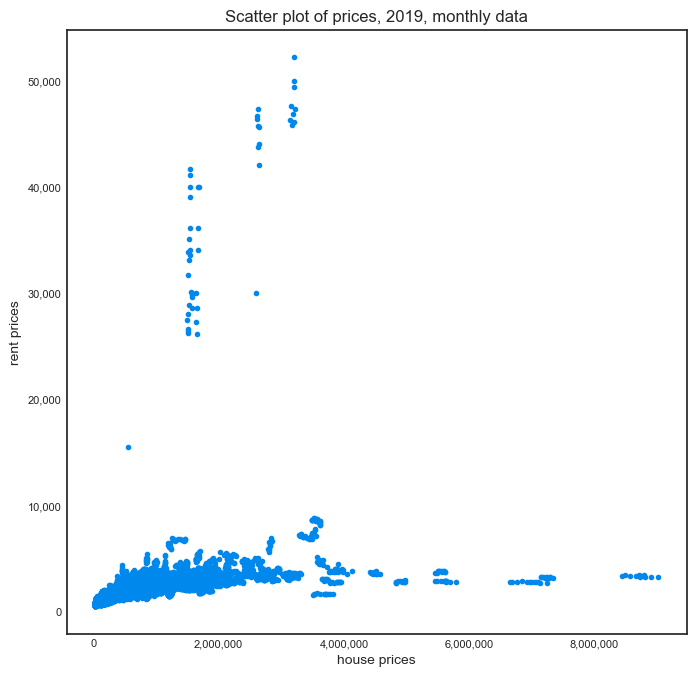

In [258]:
# quick plot, but we should get means - this is plotting up to 12 data points per zip
def scatter(df, title):
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.scatter(df['house_price'], df['rent_price'])
    ax.ticklabel_format(style='plain')
    ax.get_xaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel("house prices")
    ax.set_ylabel("rent prices")
    ax.set_title(title)
scatter(prices_CBSA_vaca_construction_pop, 'Scatter plot of prices, 2019, monthly data')
#plt.savefig('../output/initial_scatter_prices.png')

In [259]:
# but what are these crazy data points?
high_rent = prices_CBSA_vaca_construction_pop[prices_CBSA_vaca_construction_pop['rent_price'] > 10000]

In [260]:
# characteristics
print(len(high_rent))
print(high_rent['ZIP'].unique())
print(high_rent['State'].unique())
print(high_rent['City'].unique())

49
[11932 11976 11946 11963 11937 11968]
['NY']
['Bridgehampton' 'Water Mill' 'Hampton Bays' 'Sag Harbor' 'East Hampton'
 'Southampton']


In [261]:
high_houses = prices_CBSA_vaca_construction_pop[prices_CBSA_vaca_construction_pop['house_price'] > 6_000_000]

In [262]:
# characteristics
print(len(high_houses))
print(high_houses['ZIP'].unique())
print(high_houses['State'].unique())
print(high_houses['City'].unique())

36
[10075 10065 10021]
['NY']
['New York']


In [263]:
# let's exclude these from analysis - I don't think these are likely investment areas!
prices_CBSA_vaca_construction_pop = prices_CBSA_vaca_construction_pop[prices_CBSA_vaca_construction_pop['house_price'] < 6_000_000]
prices_CBSA_vaca_construction_pop = prices_CBSA_vaca_construction_pop[prices_CBSA_vaca_construction_pop['rent_price'] < 10_000]

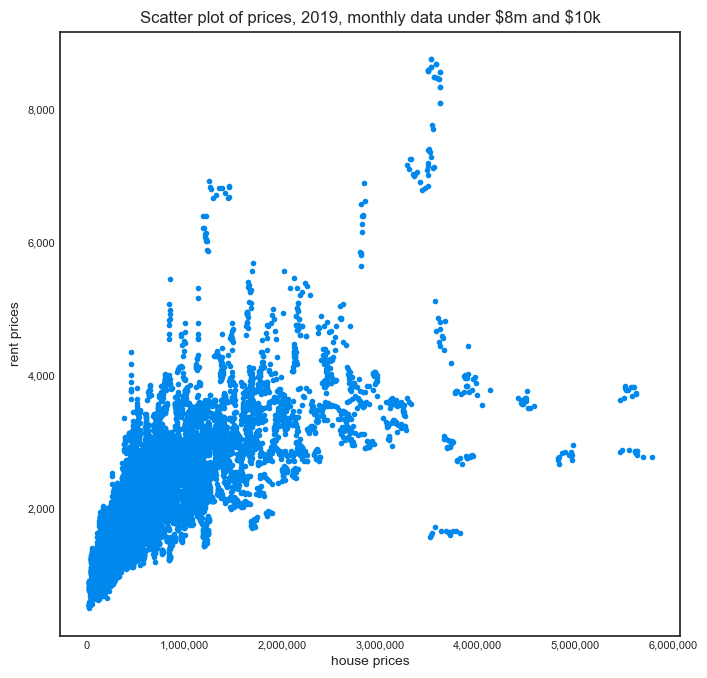

In [264]:
# plot again
scatter(prices_CBSA_vaca_construction_pop, 'Scatter plot of prices, 2019, monthly data under \$8m and \$10k')
#plt.savefig('../output/filter_scatter_prices.png')

In [265]:
prices_CBSA_vaca_construction_pop_ANALYSIS = sv.analyze(prices_CBSA_vaca_construction_pop, pairwise_analysis="on")

:FEATURES DONE:                    |█████████████████████| [100%]   00:08  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:04  -> (00:00 left)


Creating Associations graph... DONE!


In [266]:
prices_CBSA_vaca_construction_pop_ANALYSIS.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


# this concludes initial EDA - continued in aggregation notebook